I download data from: https://archive.ics.uci.edu/ml/datasets/census+income

In [1]:
!pip install econml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install dowhy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
!apt-get install python-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python-dev-is-python2' instead of 'python-dev'
pkg-config is already the newest version (0.29.1-0ubuntu4).
graphviz is already the newest version (2.42.2-3build2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libpython2-dev libpython2-stdlib libpython2.7
  libpython2.7-dev libxdot4 python-is-python2 python2 python2-dev
  python2-minimal python2.7-dev
Suggested packages:
  gvfs python2-doc python-tk
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libpython2-dev libpython2-stdlib
  libpython2.7 libpython2.7-dev libxdot4 python-dev-is-python2
  python-is-python2 python2 python2-dev python2-minimal python2.7-dev
0 upgraded, 18 newly installed, 0 to remove and 24 not upgraded.


In [12]:
import pickle
import matplotlib.pyplot as plt
import econml
import dowhy
from dowhy import CausalModel
from IPython.display import Image, display

In [7]:
user = "PouyaKhn"
repo = "causal"
src_dir = "causal_inference"
pyfile = "df_causal_inference.p"

url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url}

--2023-05-07 22:55:52--  https://raw.githubusercontent.com/PouyaKhn/causal/main/causal_inference/df_causal_inference.p
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 584841 (571K) [application/octet-stream]
Failed to rename df_causal_inference.p to df_causal_inference.p.1: (2) No such file or directory
Saving to: ‘df_causal_inference.p’

df_causal_inference 100%[===================>] 571.13K  --.-KB/s    in 0.02s   

2023-05-07 22:55:52 (35.0 MB/s) - ‘df_causal_inference.p’ saved [584841/584841]



In [8]:
df = pickle.load( open("df_causal_inference.p", "rb"))

In [11]:
df

,age,hasGraduateDegree,greaterThan50k
0,39,False,False
1,50,False,False
2,38,False,False
3,53,False,False
5,37,True,False
...,...,...,...
32556,27,False,False
32557,40,False,True
32558,58,False,False
32559,22,False,False


## Initialize Causal model and plot it

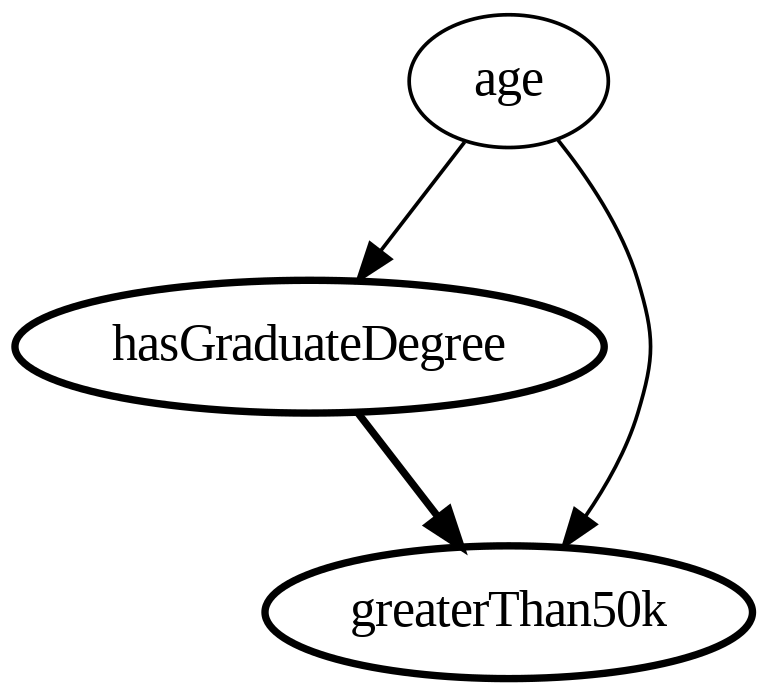

In [19]:
model = CausalModel(
    data = df,
    treatment = "hasGraduateDegree",
    outcome = "greaterThan50k",
    common_causes = "age",
)

model.view_model()
display(Image(filename="causal_model.png"))

## Generate Estimand

In [20]:
estimands = model.identify_effect(proceed_when_unidentifiable = True)
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Compute Causal Effects

In [21]:
from sklearn.ensemble import RandomForestRegressor
causal_effects = model.estimate_effect(estimands,
                                       method_name = "backdoor.econml.metalearners.TLearner",
                                       confidence_intervals = False,
                                       method_params = {"init_params":{'models':RandomForestRegressor()},
                                                        "fit_params":{}
                                                        })

print(causal_effects)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

## Realized estimand
b: greaterThan50k~hasGraduateDegree+age
Target units: ate

## Estimate
Mean value: 0.20331628485961953
Effect estimates: [[ 0.30884859]
 [ 0.21130277]
 [ 0.37086227]
 ...
 [ 0.13342335]
 [-0.01461372]
 [ 0.2020784 ]]



## Analyse causal effects distribution

(array([  74.,   67., 2473., 5234., 3176., 7644., 6119., 3911.,  408.,
          64.]),
 array([-0.28979424, -0.19557138, -0.10134853, -0.00712567,  0.08709718,
         0.18132004,  0.27554289,  0.36976575,  0.4639886 ,  0.55821146,
         0.65243431]),
 <BarContainer object of 10 artists>)

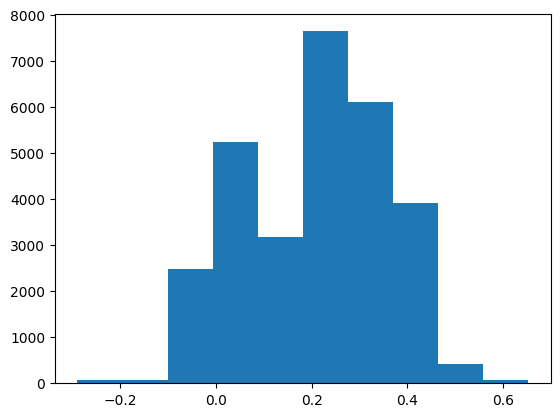

In [22]:
plt.hist(causal_effects.cate_estimates)